# Daily Electricity Demand Forecasting 

In [184]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, shapiro

In [185]:
path = "./data.csv"

data = pd.read_csv(path, sep=',', parse_dates= ['datetime']) # read csv and parse datetime column
print(data.head())
data = pd.read_csv(path, sep=",", parse_dates=["datetime"])
data = data[data["name"]=="Demanda programada PBF total"]#.set_index("datetime")
data["date"] = data["datetime"].dt.date
data.set_index("date", inplace=True) # exatract datetime and value 
data = data[["value"]]
data = data.asfreq("D")
#print(data)
data = data.rename(columns={"value" : "energy" })
#print(data)
#print(data)

data.info()

             datetime   id                            name  geoid geoname  \
0 2014-01-01 23:00:00  600  Precio mercado SPOT Diario ESP    3.0  España   
1 2014-01-02 23:00:00  600  Precio mercado SPOT Diario ESP    3.0  España   
2 2014-01-03 23:00:00  600  Precio mercado SPOT Diario ESP    3.0  España   
3 2014-01-04 23:00:00  600  Precio mercado SPOT Diario ESP    3.0  España   
4 2014-01-05 23:00:00  600  Precio mercado SPOT Diario ESP    3.0  España   

       value  
0  25.280833  
1  39.924167  
2   4.992083  
3   4.091667  
4  13.587500  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2014-01-01 to 2018-12-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  1825 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


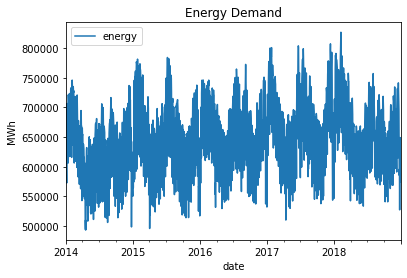

energy    0
dtype: int64


In [186]:
data.plot(title="Energy Demand")
plt.ylabel("MWh")
plt.show()

print(data.isnull().sum()) #print toatal missing values

/var/folders/lv/94r4tg0d2j1cm46gg66zs77h0000gn/T/ipykernel_1688/412100900.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week


<Figure size 1440x1152 with 0 Axes>

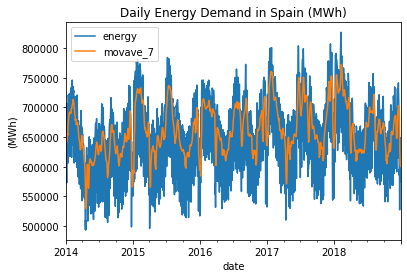

In [187]:
data["year"] = data.index.year
data["qtr"] = data.index.quarter
data["mon"] = data.index.month
data["week"] = data.index.week
data["day"] = data.index.weekday
data["ix"] = range(0,len(data))
data[["movave_7", "movstd_7"]] = data.energy.rolling(7).agg([np.mean, np.std])
data[["movave_30", "movstd_30"]] = data.energy.rolling(30).agg([np.mean, np.std])
data[["movave_90", "movstd_90"]] = data.energy.rolling(90).agg([np.mean, np.std])
data[["movave_365", "movstd_365"]] = data.energy.rolling(365).agg([np.mean, np.std])

plt.figure(figsize=(20,16))
data[["energy", "movave_7"]].plot(title="Daily Energy Demand in Spain (MWh)")
plt.ylabel("(MWh)")
plt.show()

In [188]:
"""
Analyze time series data, without relying on any statistical method like decomposing

Now use EDA: Exploratory Data Analysis
"""

mean = np.mean(data.energy.values)
print(mean)
std = np.std(data.energy.values)
print(std)
#skew = skew(data.energy.values)
#print(skew)
ex_kurt = kurtosis(data.energy)
print(ex_kurt)
#print("Skewness: {} \nKurtosis: {}".format(skew, ex_kurt+3))




662011.8225205479
62637.57726770914
-0.3947393027546333


## Negative Skewness: Data distribution is not completelly simetric and has a left tail
## Kurtosis below 3: It means that tails are slightly thinner than in a Normal distribution. It is said that the distribution is platykurtic and the chance of finding extre values is lower than in a normal distribution.

H0: Data was drawn from a Normal Distibution
Pval 2.5413487980685545e-10 is lower than significane level:0.05, therefore null hypothesis is rejected


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


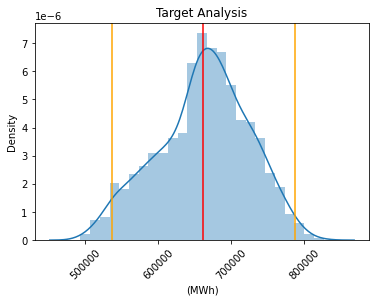

In [189]:
def shapiro_test(data, alpha=0.05):
    stat, pva1 = shapiro(data)
    print("H0: Data was drawn from a Normal Distibution")

    if (pva1 < alpha):
        print("Pval {} is lower than significane level:{}, therefore null hypothesis is rejected".format(pva1, alpha))
    else:
        print("pval {} is higher than significance level: {}, therefore null hypothesis cannot be rejected".format(pva1, alpha))
        
shapiro_test(data.energy, alpha=0.05)

sns.distplot(data.energy)
plt.title("Target Analysis")
plt.xticks(rotation=45)
plt.xlabel("(MWh)")
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
plt.show()

*Data doesn't look like normal distribution*

Rolling [window=90,center=False,axis=0,method=single]


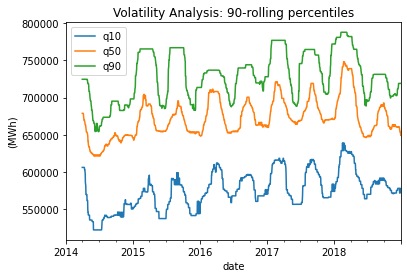

In [190]:
# Volatility Analysis

# Insert the rolling quantiles to the monthly returns
data_rolling = data.energy.rolling(window=90)
print(data_rolling)
data['q10'] = data_rolling.quantile(0.1).to_frame("q10")
#print(data['q50'])
data['q50'] = data_rolling.quantile(0.5).to_frame("q50")
data['q90'] = data_rolling.quantile(0.9).to_frame("q90")

data[["q10", "q50", "q90"]].plot(title="Volatility Analysis: 90-rolling percentiles")
plt.ylabel("(MWh)")
plt.show()

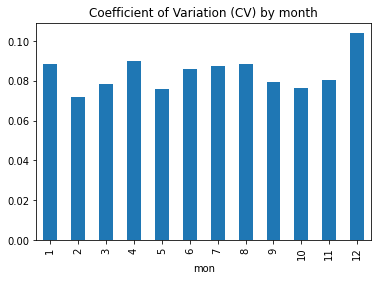

In [191]:
data.groupby("mon")["energy"].std().divide(data.groupby("mon")["energy"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by month")
plt.show()

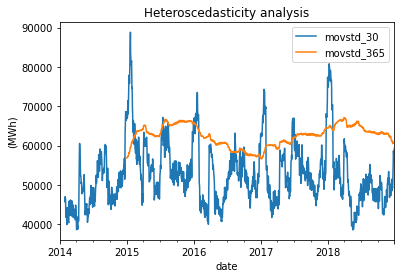

In [192]:
data[["movstd_30", "movstd_365"]].plot(title="Heteroscedasticity analysis")
plt.ylabel("(MWh)")
plt.show()

### In the short term (quaterly and monthly) volatility is changeable, but in the long term (year window) it is quite stable, therefore, candidate predictors will have to deal with seasonal pattern in variance.

# Time series Analysis: Seasonaality and Trend

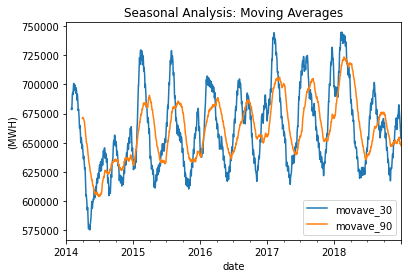

In [193]:
data [['movave_30', 'movave_90']].plot(title='Seasonal Analysis: Moving Averages')
plt.ylabel("(MWH)")
plt.show()

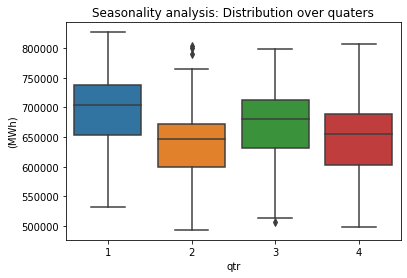

In [194]:
sns.boxplot(data=data, x="qtr", y="energy")
plt.title("Seasonality analysis: Distribution over quaters")
plt.ylabel("(MWh)")
plt.show()

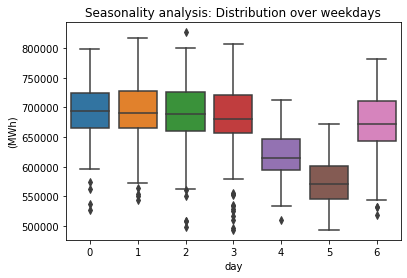

In [195]:
sns.boxplot(data=data, x="day", y="energy")
plt.title("Seasonality analysis: Distribution over weekdays")
plt.ylabel("(MWh)")
plt.show()

### There are two clear seasonal pattern in quaterters and weekdays (0 is Monday)

In [196]:
data_mon = data.energy.resample('M').agg(sum).to_frame('energy')
#print(data_mon)
data_mon['ix'] = range(0, len(data_mon))
print(data_mon[:5])


                energy  ix
date                      
2014-01-31  21017412.7   0
2014-02-28  19336398.7   1
2014-03-31  20040978.6   2
2014-04-30  17633177.7   3
2014-05-31  18572681.6   4


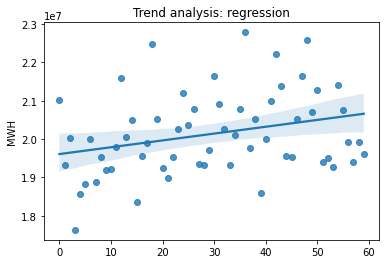

In [197]:
sns.regplot(data=data_mon, x='ix', y='energy')
plt.title('Trend analysis: regression')
plt.ylabel('MWH')
plt.xlabel("")
plt.show()

### There is a positive linear (or sligthly damped) trend in energy demand, beacause of a steady economic grownth due to recession recovery.

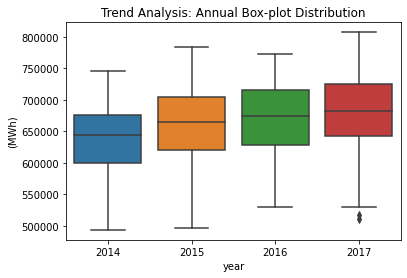

In [198]:
sns.boxplot(data=data["2014":"2017"], x="year", y="energy")
plt.title("Trend Analysis: Annual Box-plot Distribution")
plt.ylabel("(MWh)")
plt.show()

In [199]:
data=data["2014":"2017"]
data

,energy,year,qtr,mon,week,day,ix,movave_7,movstd_7,movave_30,movstd_30,movave_90,movstd_90,movave_365,movstd_365,q10,q50,q90
date,,,,,,,,,,,,,,,,,,
2014-01-01,620107.7,2014,1,1,1,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,659865.2,2014,1,1,1,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,632536.8,2014,1,1,1,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,610251.7,2014,1,1,1,5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,572534.1,2014,1,1,1,6,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,690282.0,2017,4,12,52,2,1456,647642.685714,65974.024726,718475.560000,67242.414165,671616.738889,67633.820689,678418.697808,64374.084729,573990.43,670630.95,771825.4
2017-12-28,661642.7,2017,4,12,52,3,1457,636754.471429,53762.377916,715114.796667,67487.095591,672301.977778,67210.873743,678396.532603,64378.476265,573990.43,670630.95,771825.4
2017-12-29,610071.5,2017,4,12,52,4,1458,632077.342857,54565.748619,709696.390000,69214.006046,673012.982222,66191.352061,678221.179726,64477.368907,583793.88,670630.95,771825.4


## Feature Engineering
The challenge now is to create some features in a very automated way that can deal with seasonality, trend and changes in volatility. The most basic strategy is to use lagged features and rolling window stats, but consider other advanced techniques for further research:

- Momentum and Mean reversion, like RSI in financial markets (https://en.wikipedia.org/wiki/Relative_strength_index)
- Sequence minning

Data is standardized in order to allow application of models that are sensitive to scale, like neural networks or svm. Remember that distribution shape is maintained, it only changes first and second momentum (mean and standard deviation)

date
2014-01-01   -0.668993
2014-01-02   -0.034271
2014-01-03   -0.470565
2014-01-04   -0.826343
2014-01-05   -1.428499
                ...   
2017-12-27    0.451329
2017-12-28   -0.005893
2017-12-29   -0.829220
2017-12-30   -1.324560
2017-12-31   -1.842193
Freq: D, Name: target, Length: 1461, dtype: float64


/var/folders/lv/94r4tg0d2j1cm46gg66zs77h0000gn/T/ipykernel_1688/1787726113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data.energy.add(-mean).div(std) # add target value on energy index
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

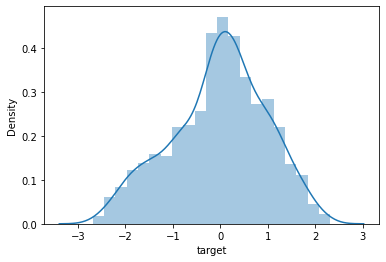

In [200]:
data['target'] = data.energy.add(-mean).div(std) # add target value on energy index
print(data['target'])
sns.distplot(data['target'])

In [201]:
features = []
corr_features=[]
targets = []
tau = 30 #forecasting periods

for t in range(1, tau+1):
    data["target_t" + str(t)] = data.target.shift(-t)
    targets.append("target_t" + str(t))
    
for t in range(1,31):
    data["feat_ar" + str(t)] = data.target.shift(t)
    #data["feat_ar" + str(t) + "_lag1y"] = data.target.shift(350)
    features.append("feat_ar" + str(t))
    #corr_features.append("feat_ar" + str(t))
    #features.append("feat_ar" + str(t) + "_lag1y")
        
    
for t in [7, 14, 30]:
    data[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = data.energy.rolling(t).agg([np.mean, np.std, np.max, np.min])
    features.append("feat_movave" + str(t))
    #corr_features.append("feat_movave" + str(t))
    features.append("feat_movstd" + str(t))
    features.append("feat_movmin" + str(t))
    features.append("feat_movmax" + str(t))
    
months = pd.get_dummies(data.mon,
                              prefix="mon",
                              drop_first=True)
months.index = data.index
data = pd.concat([data, months], axis=1)

days = pd.get_dummies(data.day,
                              prefix="day",
                              drop_first=True)
days.index = data.index
data = pd.concat([data, days], axis=1)


features = features + months.columns.values.tolist() + days.columns.values.tolist()

/var/folders/lv/94r4tg0d2j1cm46gg66zs77h0000gn/T/ipykernel_1688/3865622915.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["target_t" + str(t)] = data.target.shift(-t)
/var/folders/lv/94r4tg0d2j1cm46gg66zs77h0000gn/T/ipykernel_1688/3865622915.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feat_ar" + str(t)] = data.target.shift(t)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set

In [202]:
corr_features = ["feat_ar1", "feat_ar2", "feat_ar3", "feat_ar4", "feat_ar5", "feat_ar6", "feat_ar7", "feat_movave7", "feat_movave14", "feat_movave30"]
print(corr_features)

['feat_ar1', 'feat_ar2', 'feat_ar3', 'feat_ar4', 'feat_ar5', 'feat_ar6', 'feat_ar7', 'feat_movave7', 'feat_movave14', 'feat_movave30']


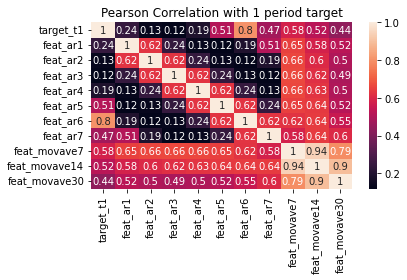

In [203]:
# Calculate correlation matrix
corr = data[["target_t1"] + corr_features].corr()

top5_mostCorrFeats = corr["target_t1"].apply(abs).sort_values(ascending=False).index.values[:6]


# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.title("Pearson Correlation with 1 period target")
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

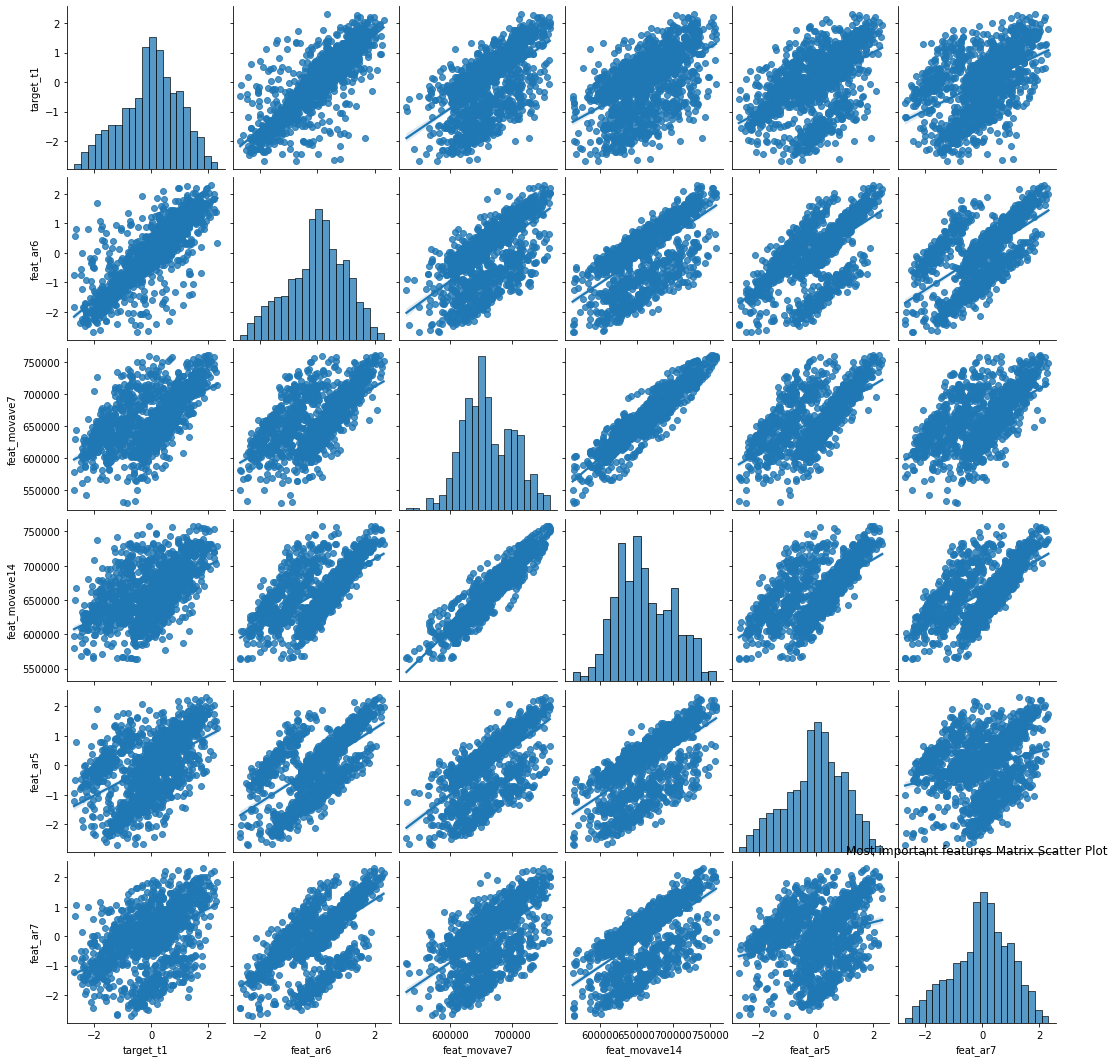

In [204]:
sns.pairplot(data=data[top5_mostCorrFeats].dropna(), kind="reg")
plt.title("Most important features Matrix Scatter Plot")
plt.show()

### There are some features that are quite strongly linearly correlated with target, like AR_6 and MOVAVE_7, let's build some models and check this assumption

# Model Building
In this step, two candidates models are build using an nice feature in Scikit-Learn such us MultiOutput Regression, it provides a framework to automatically and easily fit models to predict several target variables. (https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html)

First a baseline model (linear regression) will be fit and compared to a more advanced model, like Random Forest. A linear model does not need hyperparamenter tunning, and there is some correlation in data, so it is a strongh foundation, but there are several caveats:

Target variable is not perfectly normally distributed with constant variance
There are a lot of multicollinearity among predictors
Observations are not independent
On the other hand an advanced model, like Random Forest, needs to perform hyperparamenter tunning, tipically it is solved by using GridSearch and Cross Validation, but time series data is not suitable to be used in CV, because data is shuffled in order to build k-folds. On the other hand, Scikit-Learng provide us with a nice solution: TimeSeries Splits, that respect time structure of date and iterativelly allow us to perform GridSearch

In [205]:
print(features)
print(targets)

data_feateng = data[features + targets].dropna()
print(data_feateng)

nobs = len(data_feateng)
print("Number of observations:", nobs)

['feat_ar1', 'feat_ar2', 'feat_ar3', 'feat_ar4', 'feat_ar5', 'feat_ar6', 'feat_ar7', 'feat_ar8', 'feat_ar9', 'feat_ar10', 'feat_ar11', 'feat_ar12', 'feat_ar13', 'feat_ar14', 'feat_ar15', 'feat_ar16', 'feat_ar17', 'feat_ar18', 'feat_ar19', 'feat_ar20', 'feat_ar21', 'feat_ar22', 'feat_ar23', 'feat_ar24', 'feat_ar25', 'feat_ar26', 'feat_ar27', 'feat_ar28', 'feat_ar29', 'feat_ar30', 'feat_movave7', 'feat_movstd7', 'feat_movmin7', 'feat_movmax7', 'feat_movave14', 'feat_movstd14', 'feat_movmin14', 'feat_movmax14', 'feat_movave30', 'feat_movstd30', 'feat_movmin30', 'feat_movmax30', 'mon_2', 'mon_3', 'mon_4', 'mon_5', 'mon_6', 'mon_7', 'mon_8', 'mon_9', 'mon_10', 'mon_11', 'mon_12', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
['target_t1', 'target_t2', 'target_t3', 'target_t4', 'target_t5', 'target_t6', 'target_t7', 'target_t8', 'target_t9', 'target_t10', 'target_t11', 'target_t12', 'target_t13', 'target_t14', 'target_t15', 'target_t16', 'target_t17', 'target_t18', 'target_t19', 'tar

## Split Data

Data points in 2018 are used as a holdout data to perform a honest assessment of model performance and carry out some residual analysis (6 months)

Total number of observations:  1401
Train: (1066, 59)(1066, 30), 
Test: (366, 59)(366, 30)


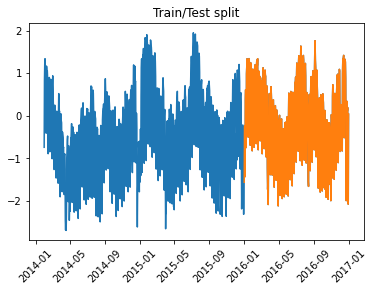

In [207]:
X_train = data_feateng.loc["2014":"2016"][features]
y_train = data_feateng.loc["2014":"2016"][targets]

X_test = data_feateng.loc["2016"][features]
y_test = data_feateng.loc["2016"][targets]

n, k = X_train.shape
print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,
                                              X_test.shape, y_test.shape))

plt.plot(y_train.index, y_train.target_t1.values, label="train")
plt.plot(y_test.index, y_test.target_t1.values, label="test")
plt.title("Train/Test split")
plt.xticks(rotation=45)
plt.show()

## Baseline Model: Linear Regression

In [211]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(X_train, y_train["target_t1"])
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], p_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )





Train RMSE: 0.31938893479722
Test RMSE: 0.3149497001602314


## Train a Random Forest with Time Series Split to tune Hyperparameters



TRAIN: 268 TEST: 266


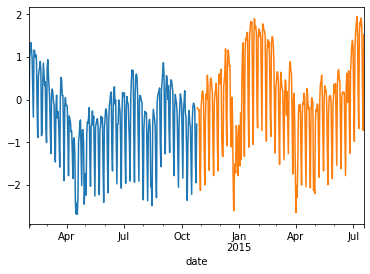

TRAIN: 534 TEST: 266


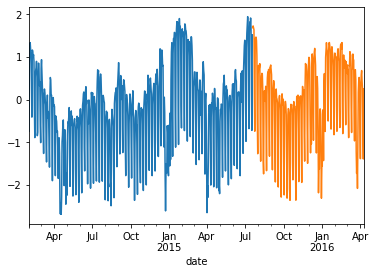

TRAIN: 730 TEST: 266


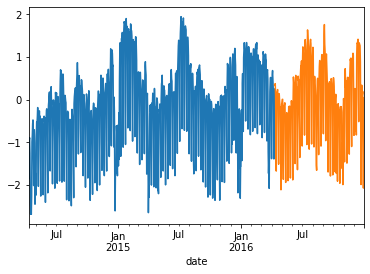

In [212]:
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
for train_index, val_index in splits.split(X_train):
    print("TRAIN:", len(train_index), "TEST:", len(val_index))
    y_train["target_t1"][train_index].plot()
    y_train["target_t1"][val_index].plot()
    plt.show()

In [213]:
from sklearn.ensemble import RandomForestRegressor

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
rfr = RandomForestRegressor()
# Create a dictionary of hyperparameters to search
rfr_grid = {"n_estimators": [500], 
        'max_depth': [3, 5, 10, 20, 30], 
        'max_features': [4, 8, 16, 32, 59], 
        'random_state': [123]}
rfr_paramGrid = ParameterGrid(rfr_grid)

def TimeSplit_ModBuild(model, paramGrid, splits, X, y):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error

    #Loop over each time split and for each
    for train_index, val_index in splits.split(X_train):
        _X_train_ = X.iloc[train_index]
        _y_train_ = y.iloc[train_index]
        _X_val_ = X.iloc[val_index]
        _y_val_ = y.iloc[val_index]

        train_scores = []
        val_scores = []
        #models = []
        
        # Loop through the parameter grid, set the hyperparameters, and save the scores
        for g in paramGrid:
            model.set_params(**g)
            model.fit(_X_train_, _y_train_)
            p_train = model.predict(_X_train_)
            p_val = model.predict(_X_val_)
            score_train = np.mean(mean_squared_error(_y_train_, p_train))
            score_val = np.mean(mean_squared_error(_y_val_, p_val))
            train_scores.append(score_train)
            val_scores.append(score_val)
            #models.append(model)
            best_idx = np.argmin(val_scores)
            
        print("Best-Fold HyperParams:: ", paramGrid[best_idx])
        print("Best-Fold Train RMSE: ", train_scores[best_idx])
        print("Best-Fold Val RMSE: ",val_scores[best_idx])
        print("\n")
        
    #Return most recent model
    return train_scores, val_scores, best_idx


CV_rfr_tup = TimeSplit_ModBuild(rfr, rfr_paramGrid, splits, X_train, y_train["target_t1"])

Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 59, 'max_depth': 10}
Best-Fold Train RMSE:  0.017334054207210892
Best-Fold Val RMSE:  0.4583740758237865


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 16, 'max_depth': 30}
Best-Fold Train RMSE:  0.02281362876495927
Best-Fold Val RMSE:  0.1891978589736061


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 8, 'max_depth': 30}
Best-Fold Train RMSE:  0.02337825372035916
Best-Fold Val RMSE:  0.1750337461058269




In [214]:
best_rfr_idx = CV_rfr_tup[2]
best_rfr_grid = rfr_paramGrid[best_rfr_idx]
best_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2016":"2017"], y_train.loc["2016":"2017", "target_t1"])

## Feature Importance

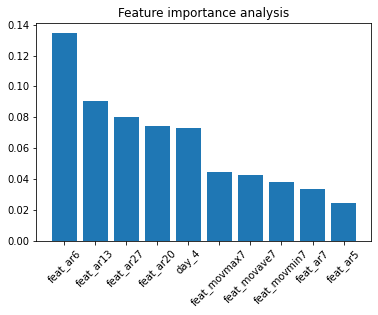

In [218]:
# Get feature importnaces from our random forest model
importances = best_rfr.feature_importances_

# Get the indesx of importances from greatest  importance to least

sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))

#Create tick labales

labels = np.array(features)[sorted_index_top]

plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analysis")

#Rotate tick labels to vertical

plt.xticks(rotation=45)
plt.show()




# Model Assessment

### Performence Metrics:

**MAPE(Mean Absolute Percentage Error)**

Even though RMSE is a very common performance metric, MAPE is very suitable to use and much easier  to understand and communicate. Let's use one period ahead model to compute MAPE in the test period




1-period ahead forecasting MAPE:  -0.04445160004503445


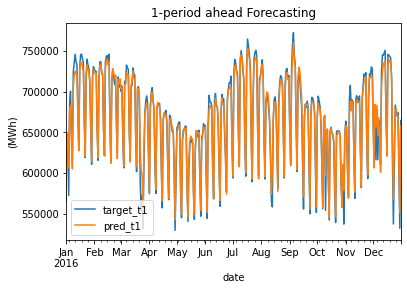

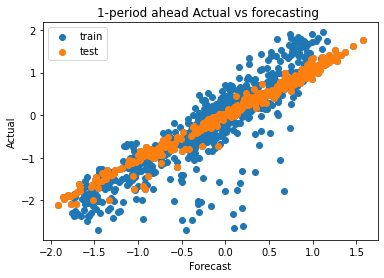

In [225]:
p_train = best_rfr.predict(X_train)
train_resid_1step = y_train["target_t1"]-p_train

p_test = best_rfr.predict(X_test)
test_resid_1step = y_test["target_t1"]-p_test

test_df = y_test[["target_t1"]]*std+mean
test_df["pred_t1"] = p_test*std+mean
test_df["resid_t1"] = test_df["target_t1"].add(-test_df["pred_t1"])
test_df["abs_resid_t1"] = abs(test_df["resid_t1"])
test_df["ape_t1"] = test_df["resid_t1"].div(test_df["target_t1"])

test_MAPE = test_df["ape_t1"].mean()*100
print("1-period ahead forecasting MAPE: ", test_MAPE)


test_df[["target_t1", "pred_t1"]].plot()

plt.title("1-period ahead Forecasting")
plt.ylabel("(MWh)")
plt.legend()
plt.show()

plt.scatter(y=y_train["target_t1"],x=p_train, label="train")
plt.scatter(y=y_test["target_t1"],x=p_test, label="test")
plt.title("1-period ahead Actual vs forecasting ")
plt.ylabel("Actual")
plt.xlabel("Forecast")
plt.legend()
plt.show()




MAPE is lower than I expected., considering that electricity demand is highly dependend on weather, and February was exceptionally cold, it is an astonishing result. However demand on sepetember is also high. 

Plotting actual vs forecasted provides a glance on how good model can fit train data and generalize to test data

# Residual Analysis

In order to perform a comprehensive exercise, a residual analysis is carried out, in order to verify:

- Is there some skewness in forecasting (tendendy to over or under forecast)?
    - Verify that residuals are normally distributed
- Does outliers impact on performance? Is there any information remaining on residuals?
    - Residual over time
    - Plot Residual vs Actual

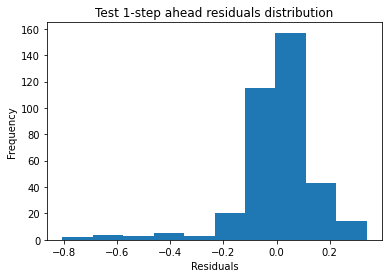

In [226]:
test_resid_1step.plot.hist(bins=10, title="Test 1-step ahead residuals distribution")
plt.xlabel("Residuals")
plt.show()

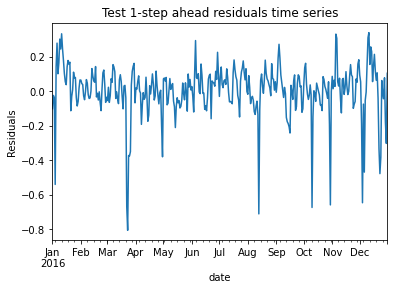

In [227]:
test_resid_1step.plot(title="Test 1-step ahead residuals time series")
plt.ylabel("Residuals")
plt.show()

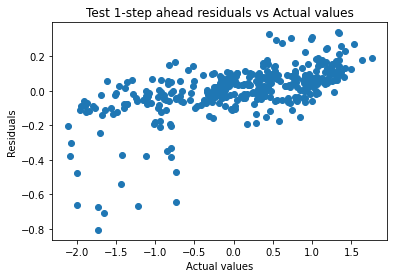

In [228]:
plt.scatter(x=y_test["target_t1"].values, y=test_resid_1step.values)
plt.title("Test 1-step ahead residuals vs Actual values")
plt.ylabel("Residuals")
plt.xlabel("Actual values")
plt.show()

# Forecasting
Muti-period ahead model building

Once we know the best hiperparam set, a new instance of the RF model can be fit on the most recent (and relevant) data. Usually, it is considered that at least 2 years are needed in order to produce a long term daily forecast. Let's re-train a family of RF models using MultiOutput Regressor feature.

MAPE test:  [1.13, 1.39, 1.5699999999999998, 1.73]


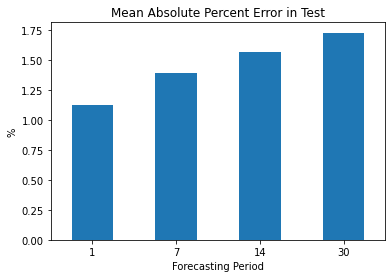

In [231]:
multi_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2016":"2017"], y_train.loc["2016":"2017"])
p_train = multi_rfr.predict(X_train)
train_resid_1step = y_train- p_train

p_test = multi_rfr.predict(X_test)
test_resid_1step = y_test- p_test

#Performance Metrics: MAPE (Mean Absolute Percent Error)

#Lastly, it is necesary to test forecasting accuracy in several periods, and assess whether it is stable.

periods = [1, 7, 14, 30]

ytest_df = y_test*std+mean
ptest_df = pd.DataFrame(data=p_test*std+mean, index=test_df.index, columns=["pred_t" + str(i) for i in range(1, 31)])
test_df = pd.concat([ytest_df, ptest_df], axis=1)

test_MAPE = []

for t in periods:
    test_df["resid_t" + str(t)] = test_df["target_t" + str(t)].add(-test_df["pred_t" + str(t)])
    test_df["abs_resid_t" + str(t)] = abs(test_df["resid_t" + str(t)])
    test_df["ape_t" + str(t)] = test_df["abs_resid_t" + str(t)].div(test_df["target_t" + str(t)])
    test_MAPE.append(round(test_df["ape_t" + str(t)].mean(), 4)*100)

print("MAPE test: ", test_MAPE)


mape_df = pd.DataFrame(index=periods, data={"test_MAPE": test_MAPE})
mape_df.plot(kind="bar", legend=False)
plt.title("Mean Absolute Percent Error in Test")
plt.xlabel("Forecasting Period")
plt.ylabel("%")
plt.xticks(rotation=0)
plt.show()



Not surprisingly, forecasting accuacy on 1 period INCREASES, more data, not always is better. Moreover, MAPE increases with forecasting horizon, but it seems quite stable.

# Actual vs Forecasted

As previously stated, a quick way to assess model fit is to plot actual vs forecasted and take a glance at data scattering

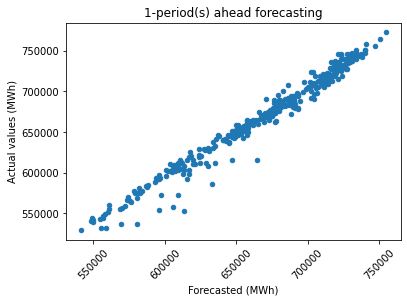

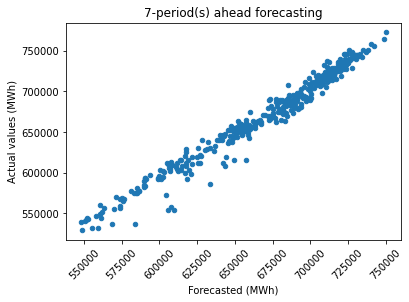

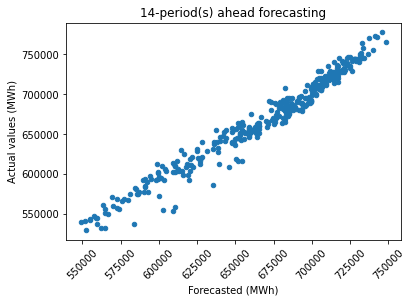

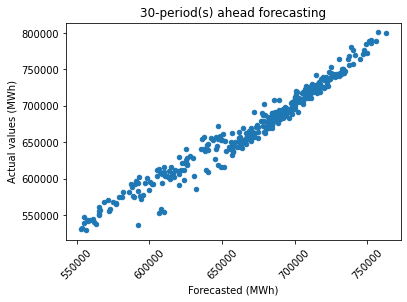

In [232]:
#f, ax = plt.subplots(nrows=3,ncols=2)
for t in periods:
    test_df[["target_t" + str(t), "pred_t" + str(t)]].plot(x="pred_t" + str(t), y="target_t" + str(t) ,kind="scatter")
    plt.title("{}-period(s) ahead forecasting".format(t))
    plt.xlabel("Forecasted (MWh)")
    plt.ylabel("Actual values (MWh)")
    plt.xticks(rotation=45)
    plt.show()

It can be seen that, as forecasting period is longer, scattering is greater, specially for extreme values

# Forecasting 30-days ahead


In [239]:
test_df.index = test_df.index.date
forecast_range = pd.date_range(start=np.max(test_df.index.values), periods=tau, freq="D")
len(forecast_range)

AttributeError: 'Index' object has no attribute 'date'

NameError: name 'forecast_range' is not defined

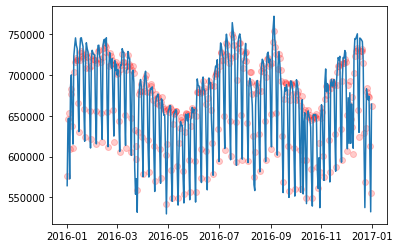

In [240]:
forecast = []
for t in range(0, tau):
    #print(-(t+1), (t))
    forecast = p_test[-(t+1):,(t)]*std+mean


test_df["target_t1"].plot()
plt.scatter(x=test_df.index, y=test_df["pred_t1"], c="r", alpha=0.2, label="test preds")
plt.plot(forecast_range, forecast, c="r", alpha=0.5, label="forecasting")
plt.ylabel("(MWh)")
plt.xticks(rotation=45)
plt.title("Forecasting Daily Electricity Consumption (MWh) in Spanish Market (2018)")
plt.show()